<a href="https://colab.research.google.com/github/yohanesnuwara/pyresim/blob/master/simulators/teasers/PyReSim_teaser2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PyReSim Teaser #2 Slightly Compressible Simulation in Reservoir with Irregular Geometry

Read the full description of Teaser 2 case [here](https://github.com/yohanesnuwara/pyresim/blob/master/docs/teaser.md#teaser-2)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
!git clone https://github.com/yohanesnuwara/pyresim

Cloning into 'pyresim'...
remote: Enumerating objects: 111, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 1142 (delta 66), reused 0 (delta 0), pack-reused 1031
Receiving objects: 100% (1142/1142), 471.12 KiB | 11.22 MiB/s, done.
Resolving deltas: 100% (691/691), done.


In [3]:
import sys
sys.path.append('/content/pyresim/functions')

In [4]:
from input_output import read_input
from boundary import boundary2d_location, boundary_flow2d_constant_pressuregrad, boundary_floweq2d
from gridding import fill_active_blocks, source2d, create_irregular_grid, maskout_inactive_blocks
from solver import lhs_coeffs2d_welltype, rhs_constant2d_welltype, fill2d_lhs_mat, fill2d_rhs_mat, solve_pressure_irregular2d
from transmissibility import transmissibility2d, transmissibility2d_boundary
from wellblock import prodrate1d, fraction_wellblock_geometric_factor
from wellsimulation import solution_well2d

Additional functions for Slightly Compressible simulation

In [5]:
from wellsimulation import well2d_report_slicomp
from synthetics import synthetic_initial_pressure2d

## Slightly Compressible simulation

In [6]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

"""""""""""
PUT THE INPUT TXT DATA
"""""""""""

filepath = '/content/pyresim/input/teasers/teaser2_input.txt'

# call the read_input function to read input data
reservoir_input, wells, west_boundary, east_boundary, south_boundary, north_boundary = read_input(filepath)

"""""""""""
SLIGHTLY INCOMPRESSIBLE INPUTS
"""""""""""

# initialize pressure (if you don't have data, create your own synthetic data,
# using function 'synthetic_initial_pressure2d'. In this case, set 4,000 psi.
p_initial = synthetic_initial_pressure2d(reservoir_input['xi'], reservoir_input['yi'],
                                         function='equilibrize', p_ref=4000)

timestep = 1 # time increment, day
schedule = 50 # how long will be simulated, days

"""""""""""
IRREGULARITIES
"""""""""""

# define grid point location of inactive blocks
xy_inactive = [(1,1), (1,6), (1,7), (1,8), (1,9),
               (2,6), (2,7), (2,8), (2,9),
               (3,6), (3,7), (3,8), (3,9),
               (4,7), (4,8), (4,9),
               (5,1), (5,7), (5,8), (5,9),
               (6,1), (6,2), (6,8), (6,9),
               (7,1), (7,2),
               (8,1), (8,2),
               (9,1), (9,7),
               (10,1), (10,7), (10,8), (10,9),
               (11,1), (11,2), (11,5), (11,6), (11,7), (11,8), (11,9),
               (12,1), (12,2), (12,5), (12,6), (12,7), (12,8), (12,9)]

"""""""""""
INPUT PROCESSING
"""""""""""

# number of blocks in x and y
xi = reservoir_input['xi']
yi = reservoir_input['yi']

# define parameters, in this case blocks are homogeneous and same in size
dx = reservoir_input['dx'] 
dy = reservoir_input['dy']
dz = reservoir_input['dz']
kx = reservoir_input['kx']
ky = reservoir_input['ky']
B = reservoir_input['B']
mu = reservoir_input['mu']

# well information (dataframe)
well_name = wells['well_name']
well_rw = wells['well_rw'] / 12  # wellbore radius, inch to ft
well_skin = wells['well_skin']
well_loc = wells['well_loc']
well_condition = wells['well_condition']
well_value = wells['well_value']
well_config = wells['well_config']

"""""""""""
GRIDDING
"""""""""""

" Create grid points "
# meshgrid the original points
x_ = np.arange(1, xi + 1)
y_ = np.arange(1, yi + 1)

x, y = np.meshgrid(x_, y_, indexing='ij')

" Classify the location of boundary with codes (1, 12, 13, etc) "
bound_loc = boundary2d_location(x, y, xi, yi)

" For Slightly Incompressible sim, there are information of CFLUID and CPORE "

# convert unit microsip to sip (* 10^-6)
reservoir_input['cfluid'] = reservoir_input['cfluid'] * 1E-6
reservoir_input['cpore'] = reservoir_input['cpore'] * 1E-6

"""""""""""
IRREGULARITIES
"""""""""""

" Create irregular grids "
x, y, x_inactive, y_inactive = create_irregular_grid(x, y, xy_inactive)

" Mask out initial pressure distribution from INACTIVE BLOCKS "
p_initial = maskout_inactive_blocks(p_initial, x_inactive, y_inactive, xi)

" Mask out the boundary codes produced before, for INACTIVE BLOCKS "
bound_loc = maskout_inactive_blocks(bound_loc.T, x_inactive, y_inactive, xi)
      
" Classify the NEW location of boundary AFTER being masked out from INACTIVE BLOCKS "
from boundary import boundary2d_irreg

bound_loc = boundary2d_irreg(bound_loc, xi, yi) 

"""""""""""
WELL INFORMATION PROCESSING
"""""""""""

# source block (production or injection well)
qsc = source2d(well_value, np.array(well_loc), xi, yi)  # call function HERE

# Calculate wellblock geometric factor
kh, r_eq, Gw = [], [], []

for i in range(len(well_config)):
    kh_, r_eq_, Gw_ = fraction_wellblock_geometric_factor(dx, dy, kx, ky, well_skin[i],
                                                          well_rw[i], dz, well_config[i])
    kh.append(kh_);
    r_eq.append(r_eq_);
    Gw.append(Gw_)

# create WELLBLOCK PROPERTY 
# inject (fill) the operating wells to 'qsc' grid that we created before
# the values won't be filled in the 'qsc' grid that has value = 0
qsc = qsc.astype('float')
qsc[qsc == 0] = np.nan

well_value = qsc
well_condition = fill_active_blocks(well_condition, qsc)
well_rw = fill_active_blocks(well_rw, qsc)
well_Gw = fill_active_blocks(np.array(Gw), qsc)
well_mu = fill_active_blocks(np.array(mu), qsc)
well_B = fill_active_blocks(np.array(B), qsc)

"""""""""""
SIMULATION
"""""""""""

def lookup(i, j, bound_dict):
    """
    Determine the type and value of boundary at a grid block
    given the boundary dictionary
    """
    if bound_dict['loc'] == 'all':
        bound_type = bound_dict['type']
        bound_value = bound_dict['value']
    else:
        x, y = i + 1, j + 1

        id1 = (np.where(np.all(bound_dict['loc'] == np.array([x, y]), axis=-1)))[0][0]
        id2 = (np.where(np.all((bound_dict['loc'][id1]) == np.array([x, y]), axis=-1)))[0][0]

        bound_type = (bound_dict['type'])[id1]
        bound_value = (bound_dict['value'])[id1]
    return bound_type, bound_value

# Create block index
block_index = np.arange(1, (xi * yi) + 1)
block_index = (np.reshape(block_index, (-1, xi))).T

# Create empty matrix for LHS and RHS
lhs_mat = np.array([[0.] * (xi * yi)] * (xi * yi))

# set up empty array for well and boundary dictionary of each block 
# for later computation of RHS and pressure solve at each timestep
well_dict = np.array([[0.] * yi] * xi).astype(dict)
boundary_dict = np.array([[0.] * yi] * xi).astype(dict)

" Start simulation "

for i in range(xi):
    for j in range(yi):

      """""""""
      ACTIVE BLOCKS
      """""""""
      if bound_loc[i,j] == bound_loc[i,j]:      

        if bound_loc[i, j] == 13:
            """""""""""
            MODIFY THIS W.R.T. THE GRID BLOCK LOCATION 
            """""""""""

            # get the TYPE and VALUE of the boundary from the BOUNDARY DICTIONARY
            b1_type, b1_value = lookup(i, j, west_boundary)
            b3_type, b3_value = lookup(i, j, south_boundary)

            # create boundary dictionary
            boundary = {'loc': np.array([1, 3]),
                        'type': np.array([b1_type, b3_type]),
                        'value': np.array([b1_value, b3_value])}

            # create non-boundary dictionary
            non_boundary = {'loc': np.array([2, 4])}

            # create well dictionary
            well = {'condition': well_condition[i, j],
                    'value': well_value[i, j],
                    'rw': well_rw[i, j],
                    'Gw': well_Gw[i, j]}

        if bound_loc[i, j] == 14:
            """""""""""
            MODIFY THIS W.R.T. THE GRID BLOCK LOCATION 
            """""""""""

            # get the TYPE and VALUE of the boundary from the BOUNDARY DICTIONARY
            b1_type, b1_value = lookup(i, j, west_boundary)
            b4_type, b4_value = lookup(i, j, north_boundary)

            # create boundary dictionary
            boundary = {'loc': np.array([1, 4]),
                        'type': np.array([b1_type, b4_type]),
                        'value': np.array([b1_value, b4_value])}

            # create non-boundary dictionary
            non_boundary = {'loc': np.array([2, 3])}

            # create well dictionary
            well = {'condition': well_condition[i, j],
                    'value': well_value[i, j],
                    'rw': well_rw[i, j],
                    'Gw': well_Gw[i, j]}

        if bound_loc[i, j] == 23:
            """""""""""
            MODIFY THIS W.R.T. THE GRID BLOCK LOCATION 
            """""""""""

            # get the TYPE and VALUE of the boundary from the BOUNDARY DICTIONARY
            b2_type, b2_value = lookup(i, j, east_boundary)
            b3_type, b3_value = lookup(i, j, south_boundary)

            # create boundary dictionary
            boundary = {'loc': np.array([2, 3]),
                        'type': np.array([b2_type, b3_type]),
                        'value': np.array([b2_value, b3_value])}

            # create non-boundary dictionary
            non_boundary = {'loc': np.array([1, 4])}

            # create well dictionary
            well = {'condition': well_condition[i, j],
                    'value': well_value[i, j],
                    'rw': well_rw[i, j],
                    'Gw': well_Gw[i, j]}

        if bound_loc[i, j] == 24:
            """""""""""
            MODIFY THIS W.R.T. THE GRID BLOCK LOCATION 
            """""""""""

            # get the TYPE and VALUE of the boundary from the BOUNDARY DICTIONARY
            b2_type, b2_value = lookup(i, j, east_boundary)
            b4_type, b4_value = lookup(i, j, north_boundary)

            # create boundary dictionary
            boundary = {'loc': np.array([2, 4]),
                        'type': np.array([b2_type, b4_type]),
                        'value': np.array([b2_value, b4_value])}

            # create non-boundary dictionary
            non_boundary = {'loc': np.array([1, 3])}

            # create well dictionary
            well = {'condition': well_condition[i, j],
                    'value': well_value[i, j],
                    'rw': well_rw[i, j],
                    'Gw': well_Gw[i, j]}

        if bound_loc[i, j] == 1:
            """""""""""
            MODIFY THIS W.R.T. THE GRID BLOCK LOCATION 
            """""""""""

            # get the TYPE and VALUE of the boundary from the BOUNDARY DICTIONARY
            b1_type, b1_value = lookup(i, j, west_boundary)

            # create boundary dictionary
            boundary = {'loc': np.array([1]),
                        'type': np.array([b1_type]),
                        'value': np.array([b1_value])}

            # create non-boundary dictionary
            non_boundary = {'loc': np.array([2, 3, 4])}

            # create well dictionary
            well = {'condition': well_condition[i, j],
                    'value': well_value[i, j],
                    'rw': well_rw[i, j],
                    'Gw': well_Gw[i, j]}

        if bound_loc[i, j] == 2:
            """""""""""
            MODIFY THIS W.R.T. THE GRID BLOCK LOCATION 
            """""""""""

            # get the TYPE and VALUE of the boundary from the BOUNDARY DICTIONARY
            b2_type, b2_value = lookup(i, j, east_boundary)

            # create boundary dictionary
            boundary = {'loc': np.array([2]),
                        'type': np.array([b2_type]),
                        'value': np.array([b2_value])}

            # create non-boundary dictionary
            non_boundary = {'loc': np.array([1, 3, 4])}

            # create well dictionary
            well = {'condition': well_condition[i, j],
                    'value': well_value[i, j],
                    'rw': well_rw[i, j],
                    'Gw': well_Gw[i, j]}

        if bound_loc[i, j] == 3:
            """""""""""
            MODIFY THIS W.R.T. THE GRID BLOCK LOCATION 
            """""""""""

            # get the TYPE and VALUE of the boundary from the BOUNDARY DICTIONARY
            b3_type, b3_value = lookup(i, j, south_boundary)

            # create boundary dictionary
            boundary = {'loc': np.array([3]),
                        'type': np.array([b3_type]),
                        'value': np.array([b3_value])}

            # create non-boundary dictionary
            non_boundary = {'loc': np.array([1, 2, 4])}

            # create well dictionary
            well = {'condition': well_condition[i, j],
                    'value': well_value[i, j],
                    'rw': well_rw[i, j],
                    'Gw': well_Gw[i, j]}

        if bound_loc[i, j] == 4:
            """""""""""
            MODIFY THIS W.R.T. THE GRID BLOCK LOCATION 
            """""""""""

            # get the TYPE and VALUE of the boundary from the BOUNDARY DICTIONARY
            b4_type, b4_value = lookup(i, j, north_boundary)

            # create boundary dictionary
            boundary = {'loc': np.array([4]),
                        'type': np.array([b4_type]),
                        'value': np.array([b4_value])}

            # create non-boundary dictionary
            non_boundary = {'loc': np.array([1, 2, 3])}

            # create well dictionary
            well = {'condition': well_condition[i, j],
                    'value': well_value[i, j],
                    'rw': well_rw[i, j],
                    'Gw': well_Gw[i, j]}

        if bound_loc[i, j] == 0:
            """""""""""
            MODIFY THIS W.R.T. THE GRID BLOCK LOCATION 
            """""""""""
            # create boundary dictionary
            # no boundary
            boundary = {'loc': None,
                        'type': None,
                        'value': None}

            # create non-boundary dictionary
            non_boundary = {'loc': np.array([1, 2, 3, 4])}

            # create well dictionary
            well = {'condition': well_condition[i, j],
                    'value': well_value[i, j],
                    'rw': well_rw[i, j],
                    'Gw': well_Gw[i, j]} 

        """""""""""
        EXTEND TO 123, 124, 134, 234, 12, 34 BOUNDARIES
        """""""""""        

        if bound_loc[i, j] == 123:
            """""""""""
            MODIFY THIS W.R.T. THE GRID BLOCK LOCATION 
            """""""""""

            # get the TYPE and VALUE of the boundary from the BOUNDARY DICTIONARY
            b1_type, b1_value = lookup(i, j, west_boundary)
            b2_type, b2_value = lookup(i, j, east_boundary)            
            b3_type, b3_value = lookup(i, j, south_boundary)

            # create boundary dictionary
            boundary = {'loc': np.array([1, 2, 3]),
                        'type': np.array([b1_type, b2_type, b3_type]),
                        'value': np.array([b1_value, b2_value, b3_value])}

            # create non-boundary dictionary
            non_boundary = {'loc': np.array([4])}

            # create well dictionary
            well = {'condition': well_condition[i, j],
                    'value': well_value[i, j],
                    'rw': well_rw[i, j],
                    'Gw': well_Gw[i, j]}    

        if bound_loc[i, j] == 124:
            """""""""""
            MODIFY THIS W.R.T. THE GRID BLOCK LOCATION 
            """""""""""

            # get the TYPE and VALUE of the boundary from the BOUNDARY DICTIONARY
            b1_type, b1_value = lookup(i, j, west_boundary)
            b2_type, b2_value = lookup(i, j, east_boundary)            
            b4_type, b4_value = lookup(i, j, north_boundary)

            # create boundary dictionary
            boundary = {'loc': np.array([1, 2, 4]),
                        'type': np.array([b1_type, b2_type, b4_type]),
                        'value': np.array([b1_value, b2_value, b4_value])}

            # create non-boundary dictionary
            non_boundary = {'loc': np.array([3])}

            # create well dictionary
            well = {'condition': well_condition[i, j],
                    'value': well_value[i, j],
                    'rw': well_rw[i, j],
                    'Gw': well_Gw[i, j]}   

        if bound_loc[i, j] == 134:
            """""""""""
            MODIFY THIS W.R.T. THE GRID BLOCK LOCATION 
            """""""""""

            # get the TYPE and VALUE of the boundary from the BOUNDARY DICTIONARY
            b1_type, b1_value = lookup(i, j, west_boundary)
            b3_type, b3_value = lookup(i, j, south_boundary)            
            b4_type, b4_value = lookup(i, j, north_boundary)

            # create boundary dictionary
            boundary = {'loc': np.array([1, 3, 4]),
                        'type': np.array([b1_type, b3_type, b4_type]),
                        'value': np.array([b1_value, b3_value, b4_value])}

            # create non-boundary dictionary
            non_boundary = {'loc': np.array([2])}

            # create well dictionary
            well = {'condition': well_condition[i, j],
                    'value': well_value[i, j],
                    'rw': well_rw[i, j],
                    'Gw': well_Gw[i, j]}   

        if bound_loc[i, j] == 234:
            """""""""""
            MODIFY THIS W.R.T. THE GRID BLOCK LOCATION 
            """""""""""

            # get the TYPE and VALUE of the boundary from the BOUNDARY DICTIONARY
            b2_type, b2_value = lookup(i, j, east_boundary)
            b3_type, b3_value = lookup(i, j, south_boundary)            
            b4_type, b4_value = lookup(i, j, north_boundary)

            # create boundary dictionary
            boundary = {'loc': np.array([2, 3, 4]),
                        'type': np.array([b2_type, b3_type, b4_type]),
                        'value': np.array([b2_value, b3_value, b4_value])}

            # create non-boundary dictionary
            non_boundary = {'loc': np.array([1])}

            # create well dictionary
            well = {'condition': well_condition[i, j],
                    'value': well_value[i, j],
                    'rw': well_rw[i, j],
                    'Gw': well_Gw[i, j]}  

        if bound_loc[i, j] == 12:
            """""""""""
            MODIFY THIS W.R.T. THE GRID BLOCK LOCATION 
            """""""""""

            # get the TYPE and VALUE of the boundary from the BOUNDARY DICTIONARY
            b1_type, b1_value = lookup(i, j, west_boundary)            
            b2_type, b2_value = lookup(i, j, east_boundary)

            # create boundary dictionary
            boundary = {'loc': np.array([1, 2]),
                        'type': np.array([b1_type, b2_type]),
                        'value': np.array([b1_value, b2_value])}

            # create non-boundary dictionary
            non_boundary = {'loc': np.array([3, 4])}

            # create well dictionary
            well = {'condition': well_condition[i, j],
                    'value': well_value[i, j],
                    'rw': well_rw[i, j],
                    'Gw': well_Gw[i, j]}   

        if bound_loc[i, j] == 34:
            """""""""""
            MODIFY THIS W.R.T. THE GRID BLOCK LOCATION 
            """""""""""

            # get the TYPE and VALUE of the boundary from the BOUNDARY DICTIONARY
            b3_type, b3_value = lookup(i, j, south_boundary)            
            b4_type, b4_value = lookup(i, j, north_boundary)

            # create boundary dictionary
            boundary = {'loc': np.array([3, 4]),
                        'type': np.array([b3_type, b4_type]),
                        'value': np.array([b3_value, b4_value])}

            # create non-boundary dictionary
            non_boundary = {'loc': np.array([1, 2])}

            # create well dictionary
            well = {'condition': well_condition[i, j],
                    'value': well_value[i, j],
                    'rw': well_rw[i, j],
                    'Gw': well_Gw[i, j]} 

        """""""""""
        DO NOT MODIFY THIS
        """""""""""

        # calculate INTER-BLOCK transmissibilities
        T = transmissibility2d(dx, dy, dz, kx, ky, mu, B)
        T = np.array(T)

        # calculate BOUNDARY transmissibilities

        if bound_loc[i, j] == 0.0:
            # Interior blocks. All side are non-boundary, so flow are all inter-block
            T = T
            boundary['T'] = None

        else:
            # Boundary blocks.
            bound_T = []
            for k in range(len(boundary['loc'])):
                a = boundary['loc'][k]
                _ = transmissibility2d_boundary(boundary['loc'][k], boundary['type'][k],
                                                dx, dy, dz, kx, ky, mu, B)
                T[a - 1] = _
                bound_T.append(_)

            boundary['T'] = bound_T

        # calculate LHS coefficients
        px_min, px_plus, py_min, py_plus, p = lhs_coeffs2d_welltype(bound_loc[i, j],
                                                                    well, T, mu, B, 
                                                                    solver='slicomp',
                                                                    reservoir_input=reservoir_input,
                                                                    timestep=1)
        well_dict[i,j] = well
        boundary_dict[i,j] = boundary

        # fill in LHS matrix
        lhs_mat = fill2d_lhs_mat(bound_loc[i, j], block_index[i, j], xi, lhs_mat,
                                  px_min, px_plus, py_min, py_plus, p)                      

      """""""""
      INACTIVE BLOCKS
      """""""""
      if bound_loc[i,j] != bound_loc[i,j]:
        # skip the loop for INACTIVE BLOCKS
        continue 

" Timestep evolution of computing RHS and solving the pressure "

# initiate solution pressure with the initial pressure array (p_initial)
p_sol = p_initial

p_sol_record = []
for k in range(schedule):

  rhs_mat = np.array([[0.] * 1] * (xi * yi))
  for i in range(xi):
    for j in range(yi):

      if bound_loc[i,j]==bound_loc[i,j]:
        """""""""
        ACTIVE BLOCKS
        """""""""
          
        # the pressure in grid block. FIRST timestep, it equals 'p_initial'
        # the NEXT timesteps, it equals the solved and updated pressure   
        p_sol = p_sol

        # calculate potential term 
        # Equals 0. the grid block is not elevated
        potential_term = 0

        # calculate RHS constants
        rhs = rhs_constant2d_welltype(boundary_dict[i,j], well_dict[i,j], 
                                      potential_term, dx, dy, dz, kx, ky, mu, B,
                                      solver='slicomp', p_initial=p_sol[i,j], 
                                      reservoir_input=reservoir_input,
                                      timestep=timestep)   
        # fill in RHS matrix
        rhs_mat = fill2d_rhs_mat(block_index[i, j], rhs_mat, rhs)  


      """""""""
      INACTIVE BLOCKS
      """""""""
      if bound_loc[i,j] != bound_loc[i,j]:
        # skip the loop for INACTIVE BLOCKS
        continue          

  """""""""""
  PRESSURE SOLVER
  """""""""""  
  p_sol = solve_pressure_irregular2d(lhs_mat, rhs_mat, x)
  p_sol_record.append(p_sol)   

"""""""""""
OUTPUT
""""""""""" 

p_initial = p_initial.reshape((1,xi,yi))
p_sol = np.concatenate((p_initial, p_sol_record), axis=0)

### Display pressure distribution at certain day

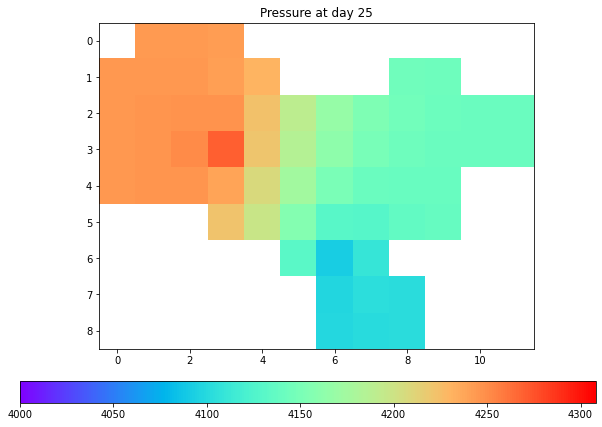

In [7]:
"""
PRESSURE AT CERTAIN DAY
"""
day = 25

min, max = np.min(p_sol[~np.isnan(p_sol)]), np.max(p_sol[~np.isnan(p_sol)]) 

fig, ax = plt.subplots(figsize=(10,6))  
im = ax.imshow(p_sol[day].T, cmap='rainbow', vmin=min, vmax=max)
ax.set_title('Pressure at day {}'.format(day))
cax = fig.add_axes([0.1, 0, 0.8, 0.05])
fig.colorbar(im, cax=cax, orientation='horizontal')

plt.show()

### Animate pressure change over 50 days

In [8]:
"""""""""""
INTERACTIVE ANIMATION (EVOLUTION OF PRESSURE)
"""""""""""

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual, ToggleButtons
import ipywidgets as widgets

# min, max = np.round(np.amin(p_sol)), np.round(np.amax(p_sol))

@interact

def display_pressure(day=(0, schedule)):
  fig, ax = plt.subplots(figsize=(10,6))  
  im = ax.imshow(p_sol[day].T, cmap='rainbow', vmin=min, vmax=max)
  ax.set_title('Simulated reservoir pressure at day {}'.format(day), size=20, pad=15)
  cax = fig.add_axes([0.1, 0, 0.8, 0.05])
  fig.colorbar(im, cax=cax, orientation='horizontal')

  plt.show() 

interactive(children=(IntSlider(value=25, description='day', max=50), Output()), _dom_classes=('widget-interac…

### Simulate well and Produce well report

In [9]:
"""""""""""
WELL SIMULATION
"""""""""""

# create well dataframe
B = np.full(len(well_name), reservoir_input['B'])
mu = np.full(len(well_name), reservoir_input['mu'])
well_df = pd.DataFrame.from_dict(wells)
well_df['well_mu'], well_df['well_B'], well_df['well_Gw'] = mu, B, Gw


# input the name of well of interest
well_name1 = 'W-3'
well_report1 = well2d_report_slicomp(well_name1, well_df, p_sol, schedule=schedule)

well_name2 = 'W-1'
well_report2 = well2d_report_slicomp(well_name2, well_df, p_sol, schedule=schedule)

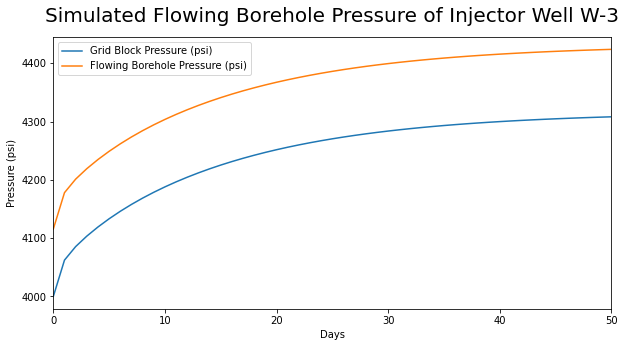

In [10]:
plt.figure(figsize=(10,5))

plt.plot(well_report1['time (day)'], well_report1['grid block pressure (psi)'], label='Grid Block Pressure (psi)')
plt.plot(well_report1['time (day)'], well_report1['fbhp_sol (psi)'], label='Flowing Borehole Pressure (psi)')
plt.xlabel('Days'); plt.ylabel('Pressure (psi)')
plt.xlim(0, schedule)
plt.title('Simulated Flowing Borehole Pressure of Injector Well W-3', size=20, pad=15)
plt.legend()
plt.show()

In [11]:
# well report of injector well W-3 the first 10 days
well_report1.head(10)

,time (day),grid block pressure (psi),fbhp_sol (psi),rate_sol (STB/D)
0,0,4000.000000,4115.701231,2600.0
1,1,4062.302372,4178.003603,2600.0
2,2,4085.506807,4201.208039,2600.0
3,3,4103.451531,4219.152762,2600.0
4,4,4119.128791,4234.830022,2600.0
5,5,4133.228339,4248.929570,2600.0
6,6,4146.061324,4261.762555,2600.0
7,7,4157.821565,4273.522796,2600.0
8,8,4168.648789,4284.350020,2600.0
9,9,4178.651017,4294.352249,2600.0


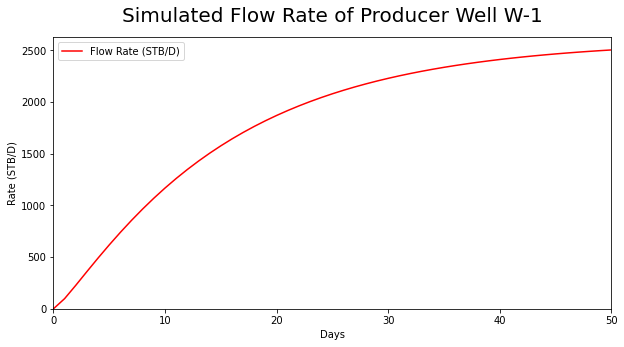

In [12]:
plt.figure(figsize=(10,5))

plt.plot(well_report2['time (day)'], np.abs(well_report2['rate_sol (STB/D)']), color='red', label='Flow Rate (STB/D)')
plt.xlabel('Days'); plt.ylabel('Rate (STB/D)')
plt.title('Simulated Flow Rate of Producer Well W-1', size=20, pad=15)
plt.xlim(0, schedule)
plt.ylim(ymin=0)
plt.legend()
plt.show()

In [13]:
# well report of producer well W-3 the first 10 days
well_report2.head(10)

,time (day),grid block pressure (psi),fbhp_sol (psi),rate_sol (STB/D)
0,0,4000.000000,4000.0,-0.000000
1,1,4004.380610,4000.0,-98.439622
2,2,4010.109648,4000.0,-227.180679
3,3,4016.037169,4000.0,-360.381977
4,4,4021.870998,4000.0,-491.477875
5,5,4027.520009,4000.0,-618.420598
6,6,4032.941011,4000.0,-740.239564
7,7,4038.109834,4000.0,-856.391650
8,8,4043.014321,4000.0,-966.603675
9,9,4047.650856,4000.0,-1070.794364
